# **Students’ Problem-Solving Strategies and Performance Analysis**

The problem at hand involves predicting whether a student will eventually succeed in solving a programming task within an intelligent tutoring system, irrespective of whether they succeed on their first attempt. We aim to develop machine learning models that can forecast the likelihood of a student achieving success in programming tasks based on their previous interactions and performance within the tutoring system. This entails analyzing the temporal
dynamics of students’ interactions, their engagement patterns, and various contextual factors that may influence their eventual success.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## **Load Datasets**

The dataset used in the challenge originates from a study of novice Python programmers working with the ITAP (Intelligent Tutoring for the Active Processing) intelligent tutoring system. The study was conducted over a period of 7 weeks and involved 89 students working on 38 programming problems. The dataset captures the interactions of these students with the ITAP system, including their attempts at solving problems, request for hints, and feedback
received from test cases. Each record in the dataset represents an event, such as a submission or a hint request, made by a student on
a specific problem.

In [2]:
main_table = pd.read_csv("MainTable.csv")
predict = pd.read_csv("Predict.csv")

In [3]:
main_table

,EventType,EventID,Order,SubjectID,ToolInstances,CodeStateID,ServerTimestamp,ProblemID,Correct
0,Submit,f48cba2510087c502dde920d948b364b,1373,S002,ITAP; Python,1061,2016-02-05T19:46:00,nearestBusStop,True
1,Submit,93232279e317e6a46f6bdf001ab13a39,1374,S002,ITAP; Python,1062,2016-02-05T19:48:00,backwardsCombine,True
2,X-HintRequest,4468830a73173d348adbb2159ee9a0fa,1375,S002,ITAP; Python,1063,2016-02-05T19:49:00,firstAndLast,False
3,X-HintRequest,2961b2aedf2483e7cf584a43aca4192e,1376,S002,ITAP; Python,1064,2016-02-05T19:50:00,firstAndLast,False
4,X-HintRequest,0f36ef933aaf49a51243ec78543a995d,1377,S002,ITAP; Python,1065,2016-02-05T19:51:00,firstAndLast,False
...,...,...,...,...,...,...,...,...,...
3103,Submit,3b44b9d28f394f59deec267e13d5a3aa,2874,SA,ITAP; Python,2200,2016-02-23T19:35:00,createNumberBlock,False
3104,Submit,41240ef7a5c108d90e2ece0fef79c90d,2875,SA,ITAP; Python,2201,2016-02-23T19:38:00,createNumberBlock,False
3105,Submit,074e6a22c047780a94bfc46db9420cf6,2876,SA,ITAP; Python,2201,2016-02-23T19:41:00,createNumberBlock,False
3106,Submit,caf806d17f6be2da36bd2daabbe97de2,2946,SA,ITAP; Python,2254,2016-02-27T02:28:00,listOfLists,False


In [4]:
predict

,SubjectID,ProblemID,StartOrder,FirstCorrect,EverCorrect,UsedHint,Attempts
0,S002,nearestBusStop,1373,True,True,False,1
1,S002,backwardsCombine,1374,True,True,False,1
2,S002,firstAndLast,1375,False,True,True,15
3,S002,singlePigLatin,1398,False,True,True,6
4,S002,hasTwoDigits,1405,False,True,False,2
...,...,...,...,...,...,...,...
724,SA,overNineThousand,2554,True,True,False,1
725,SA,hasTwoDigits,2556,False,True,True,12
726,SA,canDrinkAlcohol,2596,False,True,False,11
727,SA,isEvenPositiveInt,2609,False,True,False,5


## **Data Integration**

There are two main datasets - `main_table` contains details of all the events in the dataset and `predict` table contains rows for each student-problem pair. In this section, we are merging both tables that are joined based on StudentID and ProblemID.

In [5]:
Data = pd.merge(main_table,predict, on=["SubjectID", "ProblemID"], how="outer")
Data=pd.DataFrame(Data)
Data

,EventType,EventID,Order,SubjectID,ToolInstances,CodeStateID,ServerTimestamp,ProblemID,Correct,StartOrder,FirstCorrect,EverCorrect,UsedHint,Attempts
0,Submit,f48cba2510087c502dde920d948b364b,1373,S002,ITAP; Python,1061,2016-02-05T19:46:00,nearestBusStop,True,1373.0,True,True,False,1.0
1,Submit,93232279e317e6a46f6bdf001ab13a39,1374,S002,ITAP; Python,1062,2016-02-05T19:48:00,backwardsCombine,True,1374.0,True,True,False,1.0
2,X-HintRequest,4468830a73173d348adbb2159ee9a0fa,1375,S002,ITAP; Python,1063,2016-02-05T19:49:00,firstAndLast,False,1375.0,False,True,True,15.0
3,X-HintRequest,2961b2aedf2483e7cf584a43aca4192e,1376,S002,ITAP; Python,1064,2016-02-05T19:50:00,firstAndLast,False,1375.0,False,True,True,15.0
4,X-HintRequest,0f36ef933aaf49a51243ec78543a995d,1377,S002,ITAP; Python,1065,2016-02-05T19:51:00,firstAndLast,False,1375.0,False,True,True,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,Submit,f5905efc65f5dca732be663f988d5439,2870,SA,ITAP; Python,2196,2016-02-23T16:04:00,findTheCircle,NaN,NaN,NaN,NaN,NaN,NaN
3104,Submit,0da322cfc58faa66a3878363169a9840,2871,SA,ITAP; Python,2197,2016-02-23T16:11:00,findTheCircle,NaN,NaN,NaN,NaN,NaN,NaN
3105,Submit,91170009f67a36212ec1eb13a15d7eed,2872,SA,ITAP; Python,2198,2016-02-23T16:11:00,findTheCircle,NaN,NaN,NaN,NaN,NaN,NaN
3106,Submit,caf806d17f6be2da36bd2daabbe97de2,2946,SA,ITAP; Python,2254,2016-02-27T02:28:00,listOfLists,False,NaN,NaN,NaN,NaN,NaN


## **Feature Selection**

In this section, we are dropping all the redundant features from the dataset. ToolInstances are same in every event and EventID is not useful in performance prediction. Hence, we dropped both these columns.

In [6]:
Data = Data.drop(["ToolInstances","EventID"], axis=1)
Data

,EventType,Order,SubjectID,CodeStateID,ServerTimestamp,ProblemID,Correct,StartOrder,FirstCorrect,EverCorrect,UsedHint,Attempts
0,Submit,1373,S002,1061,2016-02-05T19:46:00,nearestBusStop,True,1373.0,True,True,False,1.0
1,Submit,1374,S002,1062,2016-02-05T19:48:00,backwardsCombine,True,1374.0,True,True,False,1.0
2,X-HintRequest,1375,S002,1063,2016-02-05T19:49:00,firstAndLast,False,1375.0,False,True,True,15.0
3,X-HintRequest,1376,S002,1064,2016-02-05T19:50:00,firstAndLast,False,1375.0,False,True,True,15.0
4,X-HintRequest,1377,S002,1065,2016-02-05T19:51:00,firstAndLast,False,1375.0,False,True,True,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3103,Submit,2870,SA,2196,2016-02-23T16:04:00,findTheCircle,NaN,NaN,NaN,NaN,NaN,NaN
3104,Submit,2871,SA,2197,2016-02-23T16:11:00,findTheCircle,NaN,NaN,NaN,NaN,NaN,NaN
3105,Submit,2872,SA,2198,2016-02-23T16:11:00,findTheCircle,NaN,NaN,NaN,NaN,NaN,NaN
3106,Submit,2946,SA,2254,2016-02-27T02:28:00,listOfLists,False,NaN,NaN,NaN,NaN,NaN


## **Handle Categorical And Missing Values**



We are converting the categorical features into numerical values using One Hot Encoding. Additionally, all the null values are handled using KNN Imputer.

In [7]:
Data.dtypes

EventType           object
Order                int64
SubjectID           object
CodeStateID          int64
ServerTimestamp     object
ProblemID           object
Correct             object
StartOrder         float64
FirstCorrect        object
EverCorrect         object
UsedHint            object
Attempts           float64
dtype: object

In [8]:
Data["ProblemID"].value_counts()

ProblemID
oneToN               287
kthDigit             274
helloWorld           218
howManyEggCartons    198
isPunctuation        158
isEvenPositiveInt    157
nearestBusStop       137
createNumberBlock    121
hasTwoDigits         117
firstAndLast         114
isSubstring          107
convertToDegrees     107
singlePigLatin        94
canDrinkAlcohol       83
sumOfDigits           82
findRoot              75
raiseToPower          75
doubleX               75
leftoverCandy         74
anyLowercase          72
isPrime               57
reduceToPositive      56
intToFloat            51
overNineThousand      50
backwardsCombine      45
carefulSquareRoot     33
middleElement         30
secondHalf            24
stockChange           24
castString            22
treasureHunt          21
factorial             18
fibonacci             17
listOfLists           10
gcd                    8
mostAnagrams           6
findTheCircle          6
friendOfFriends        5
Name: count, dtype: int64

In [9]:
Data["SubjectID"].value_counts()

SubjectID
S535    256
SA      189
S150    177
S053    143
S211    128
       ... 
S117      2
S481      2
S377      1
S665      1
S693      1
Name: count, Length: 89, dtype: int64

In [10]:
Data.isnull().sum()

EventType            0
Order                0
SubjectID            0
CodeStateID          0
ServerTimestamp      0
ProblemID            0
Correct             33
StartOrder         719
FirstCorrect       719
EverCorrect        719
UsedHint           719
Attempts           719
dtype: int64

In [11]:
Data[Data.isnull().any(axis=1)]

,EventType,Order,SubjectID,CodeStateID,ServerTimestamp,ProblemID,Correct,StartOrder,FirstCorrect,EverCorrect,UsedHint,Attempts
38,Submit,1433,S002,1107,2016-02-07T00:44:00,isSubstring,False,NaN,NaN,NaN,NaN,NaN
39,X-HintRequest,1434,S002,1107,2016-02-07T00:44:00,isSubstring,False,NaN,NaN,NaN,NaN,NaN
40,X-HintRequest,1435,S002,1108,2016-02-07T00:45:00,isSubstring,False,NaN,NaN,NaN,NaN,NaN
91,Submit,1843,S011,1431,2016-02-13T07:39:00,isSubstring,False,NaN,NaN,NaN,NaN,NaN
92,Submit,1844,S011,1432,2016-02-13T07:40:00,isSubstring,True,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3103,Submit,2870,SA,2196,2016-02-23T16:04:00,findTheCircle,NaN,NaN,NaN,NaN,NaN,NaN
3104,Submit,2871,SA,2197,2016-02-23T16:11:00,findTheCircle,NaN,NaN,NaN,NaN,NaN,NaN
3105,Submit,2872,SA,2198,2016-02-23T16:11:00,findTheCircle,NaN,NaN,NaN,NaN,NaN,NaN
3106,Submit,2946,SA,2254,2016-02-27T02:28:00,listOfLists,False,NaN,NaN,NaN,NaN,NaN


In [12]:
categorical_features = ['EventType', 'SubjectID', 'ProblemID']
encoder = OneHotEncoder(drop="first", sparse=False)

# Use loc to select columns by names
encoded_features = encoder.fit_transform(Data.loc[:, categorical_features])

# Create DataFrame of encoded features with column names
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Concatenate numerical and encoded categorical features
all_features = pd.concat([Data.drop(columns=categorical_features), encoded_df], axis=1)

# Exclude "ServerTimestamp" from imputation process
imputation_features = all_features.drop(columns=["ServerTimestamp"])

# Use KNNImputer to fill missing values
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(imputation_features)

# Convert back to DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=imputation_features.columns)

binary_columns = ['Correct', 'EverCorrect', 'FirstCorrect', 'UsedHint']

# Define threshold for binarization
threshold = 0.5

# Iterate over binary columns and binarize values
for column in binary_columns:
    imputed_df[column] = (imputed_df[column] > threshold).astype(int)

# Concatenate "ServerTimestamp" back to the DataFrame
imputed_df["ServerTimestamp"] = pd.to_datetime(Data['ServerTimestamp']).astype(int) / 10**9
imputed_df

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Order,CodeStateID,Correct,StartOrder,FirstCorrect,EverCorrect,UsedHint,Attempts,EventType_X-HintRequest,SubjectID_S011,...,ProblemID_oneToN,ProblemID_overNineThousand,ProblemID_raiseToPower,ProblemID_reduceToPositive,ProblemID_secondHalf,ProblemID_singlePigLatin,ProblemID_stockChange,ProblemID_sumOfDigits,ProblemID_treasureHunt,ServerTimestamp
0,1373.0,1061.0,1,1373.0,1,1,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.454702e+09
1,1374.0,1062.0,1,1374.0,1,1,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.454702e+09
2,1375.0,1063.0,0,1375.0,0,1,1,15.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.454702e+09
3,1376.0,1064.0,0,1375.0,0,1,1,15.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.454702e+09
4,1377.0,1065.0,0,1375.0,0,1,1,15.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.454702e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,2870.0,2196.0,0,2711.2,0,1,0,4.6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.456243e+09
3104,2871.0,2197.0,0,2711.2,0,1,0,4.6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.456244e+09
3105,2872.0,2198.0,0,2711.2,0,1,0,4.6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.456244e+09
3106,2946.0,2254.0,0,2948.0,0,1,0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.456540e+09


In [13]:
imputed_df.isnull().sum()

Order                       0
CodeStateID                 0
Correct                     0
StartOrder                  0
FirstCorrect                0
                           ..
ProblemID_singlePigLatin    0
ProblemID_stockChange       0
ProblemID_sumOfDigits       0
ProblemID_treasureHunt      0
ServerTimestamp             0
Length: 135, dtype: int64

In [14]:
Data["Correct"] = imputed_df["Correct"]
Data["EverCorrect"] = imputed_df["EverCorrect"]
Data["UsedHint"] = imputed_df["UsedHint"]
Data["Attempts"] = imputed_df["Attempts"]
Data["FirstCorrect"] = imputed_df["FirstCorrect"]
Data["StartOrder"] = imputed_df["StartOrder"]
Data

,EventType,Order,SubjectID,CodeStateID,ServerTimestamp,ProblemID,Correct,StartOrder,FirstCorrect,EverCorrect,UsedHint,Attempts
0,Submit,1373,S002,1061,2016-02-05T19:46:00,nearestBusStop,1,1373.0,1,1,0,1.0
1,Submit,1374,S002,1062,2016-02-05T19:48:00,backwardsCombine,1,1374.0,1,1,0,1.0
2,X-HintRequest,1375,S002,1063,2016-02-05T19:49:00,firstAndLast,0,1375.0,0,1,1,15.0
3,X-HintRequest,1376,S002,1064,2016-02-05T19:50:00,firstAndLast,0,1375.0,0,1,1,15.0
4,X-HintRequest,1377,S002,1065,2016-02-05T19:51:00,firstAndLast,0,1375.0,0,1,1,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3103,Submit,2870,SA,2196,2016-02-23T16:04:00,findTheCircle,0,2711.2,0,1,0,4.6
3104,Submit,2871,SA,2197,2016-02-23T16:11:00,findTheCircle,0,2711.2,0,1,0,4.6
3105,Submit,2872,SA,2198,2016-02-23T16:11:00,findTheCircle,0,2711.2,0,1,0,4.6
3106,Submit,2946,SA,2254,2016-02-27T02:28:00,listOfLists,0,2948.0,0,1,0,6.0


In [15]:
Data.isnull().sum()

EventType          0
Order              0
SubjectID          0
CodeStateID        0
ServerTimestamp    0
ProblemID          0
Correct            0
StartOrder         0
FirstCorrect       0
EverCorrect        0
UsedHint           0
Attempts           0
dtype: int64

## **Visualizations**

### Success rate over a period of time
This graph depicts the success rate of students over time, illustrating fluctuations rather than a consistent trend. Notably, there are spikes indicating instances where a significant number of problems were successfully solved. By analyzing these spikes, we can identify the specific dates when students exhibited peak performance in problem-solving, potentially indicating periods of heightened comprehension or effective learning strategies.

<ipython-input-16-77b2f852776f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions['ServerTimestamp'] = pd.to_datetime(submissions['ServerTimestamp'])


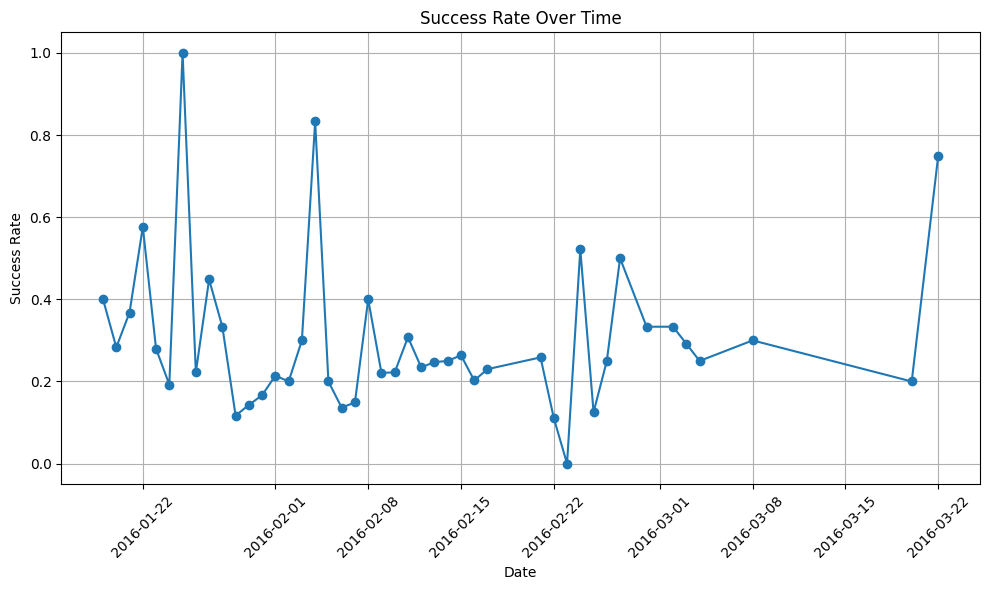

In [16]:
# Filter data for submissions
#submissions = X_train[X_train['EventType'] == 'Submit']
submissions = Data[Data['EventType'] == 'Submit']
# Convert ServerTime to datetime
submissions['ServerTimestamp'] = pd.to_datetime(submissions['ServerTimestamp'])

# Calculate success rate by day
success_rate = submissions.groupby(submissions['ServerTimestamp'].dt.date)['Correct'].mean()

# Plot success rate over time
plt.figure(figsize=(10, 6))
plt.plot(success_rate.index, success_rate.values, marker='o', linestyle='-')
plt.title('Success Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Success Rate')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Success rate vs Number of Attempts
This graph visualizes the trend of success rates among students as they make multiple attempts at a programming problem. Each line on the graph represents the collective journey of all students, where the x-axis denotes the number of attempts made, and the y-axis represents the success rate achieved. By observing the overall trend, we can discern whether there exists a convergence towards higher success rates with increasing attempts, indicating an improvement in students' understanding and proficiency related to the specific problem over time. This visualization helps in assessing the effectiveness of learning strategies and the learning curve of students in mastering programming concepts through iterative problem-solving.

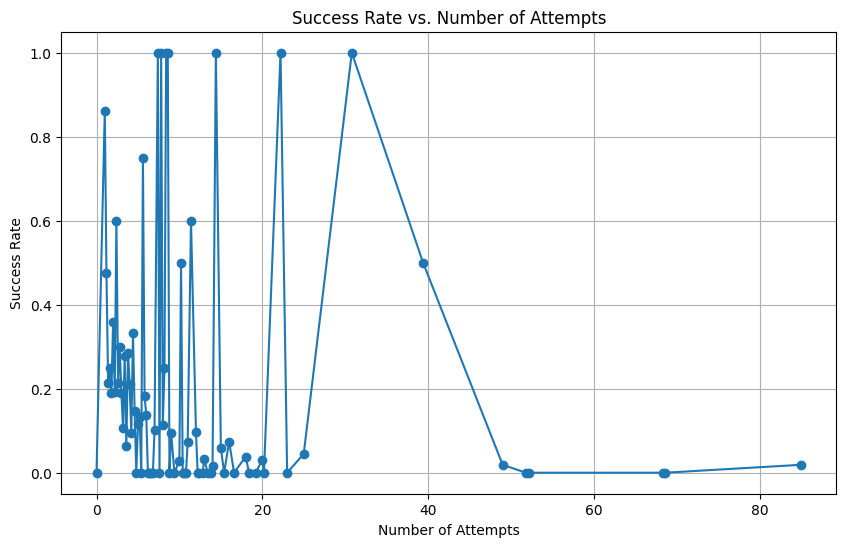

In [17]:
success_rate_data = Data.groupby('Attempts')['Correct'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(success_rate_data['Attempts'], success_rate_data['Correct'], marker='o', linestyle='-')
plt.title('Success Rate vs. Number of Attempts')
plt.xlabel('Number of Attempts')
plt.ylabel('Success Rate')
plt.grid(True)
plt.show()

### Correlation of Attempts, Hints, FirstCorrect, EverCorrect
The correlation matrix reveals an insightful relationship between two variables: the number of hints utilized and the likelihood of correctly solving a problem at any point. Surprisingly, there exists a negative correlation between these factors, indicating that the probability of solving a problem correctly does not increase with the number of hints employed. This suggests that the effectiveness of hints in aiding problem-solving may be limited or that other factors play a more substantial role in determining success, highlighting the need for further investigation into effective learning strategies.

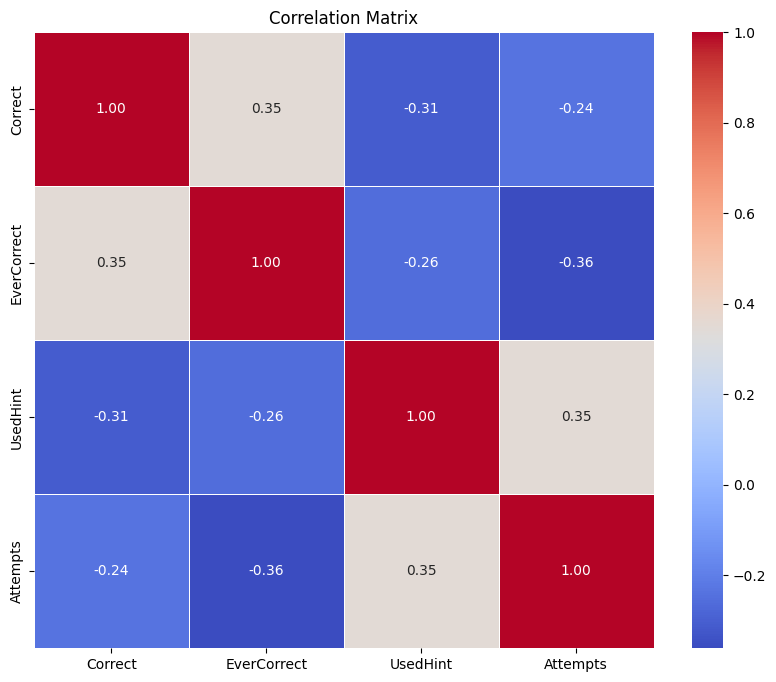

In [18]:
# Filter relevant columns
relevant_columns = ['Correct', 'EverCorrect', 'UsedHint', 'Attempts']
filtered_data = Data[relevant_columns]

# Compute correlation matrix
correlation_matrix = filtered_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Student vs Number of attempts for each problem
This heatmap illustrates the level of difficulty encountered by each student when tackling different problems. The intensity of color corresponds to the frequency of attempts made by each student for a particular problem. Darker areas indicate problems that were attempted more frequently, potentially suggesting greater difficulty or complexity, while brighter areas represent problems that were attempted less frequently. This visualization allows for a comparative analysis of students' engagement and persistence across various problem sets.

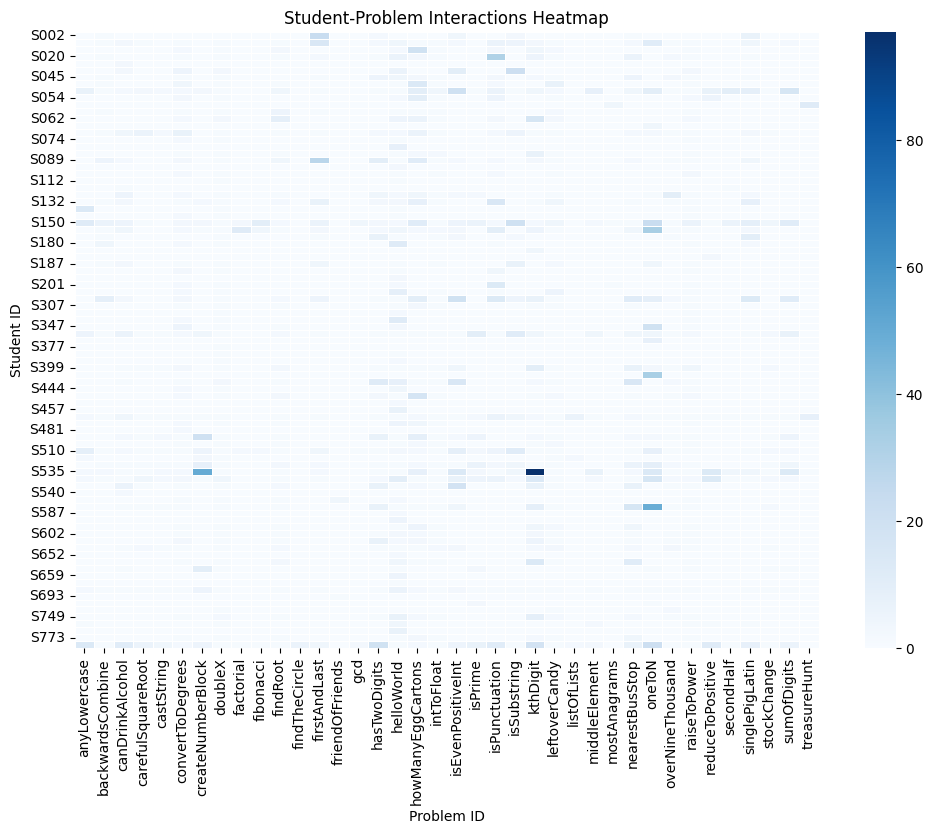

In [19]:
# Pivot the DataFrame to create a matrix of student-problem interactions
interaction_matrix = Data.pivot_table(index='SubjectID', columns='ProblemID', values='Order', aggfunc='count', fill_value=0)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(interaction_matrix, cmap='Blues', fmt='g', cbar=True, linewidths=0.5)
plt.title('Student-Problem Interactions Heatmap')
plt.xlabel('Problem ID')
plt.ylabel('Student ID')
plt.show()

### Determine the percentage of attempts in which hint is used for each problem
The analysis indicates that the problem "isPunctuation" necessitated the highest number of hints, while "leftoverCandy" required the least. This observation suggests that "isPunctuation" is comparatively more challenging than "leftoverCandy." By examining the disparity in hint usage across these problems, we infer that students encountered greater difficulty in understanding and solving "isPunctuation" compared to "leftoverCandy."

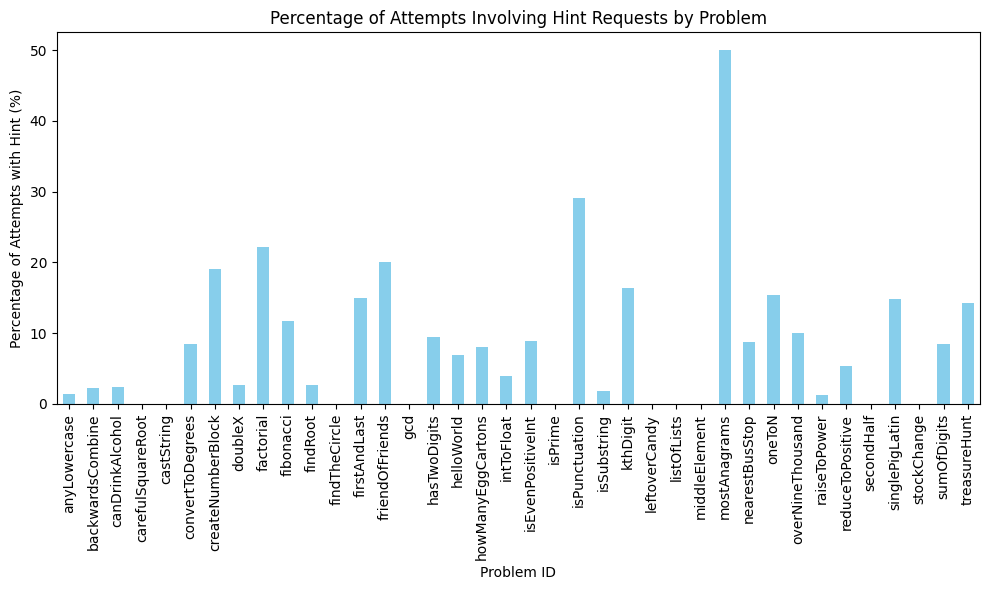

In [20]:
# Filter relevant columns
relevant_columns = ['SubjectID', 'ProblemID', 'EventType']
filtered_data = Data[relevant_columns]

# Count the number of hint requests per problem
hint_requests_per_problem = filtered_data[filtered_data['EventType'] == 'X-HintRequest'].groupby('ProblemID').size()

# Count the total number of attempts per problem
total_attempts_per_problem = filtered_data.groupby('ProblemID').size()

# Calculate the percentage of hint usage for each problem
percentage_hint_usage = (hint_requests_per_problem / total_attempts_per_problem) * 100

# Plot the data
plt.figure(figsize=(10, 6))
percentage_hint_usage.plot(kind='bar', color='skyblue')
plt.title('Percentage of Attempts Involving Hint Requests by Problem')
plt.xlabel('Problem ID')
plt.ylabel('Percentage of Attempts with Hint (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Attemps and Hint Requests vs Time
The graph indicates a peak in submissions occurring before January 22, 2016, accompanied by a notable decrease in the number of hints used during this period. This pattern suggests that a significant number of students successfully solved problems without resorting to hints for assistance, particularly during their initial attempts. This observation highlights the effectiveness of students' problem-solving skills and comprehension prior to the specified date.

<Figure size 1200x600 with 0 Axes>

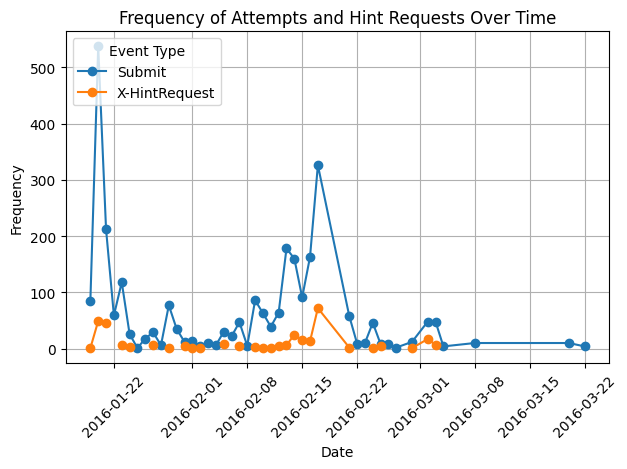

In [21]:
# Convert ServerTime to datetime format
new_data = Data.copy()
new_data['ServerTimestamp'] = pd.to_datetime(new_data['ServerTimestamp'])

# Filter relevant columns
relevant_columns = ['ServerTimestamp', 'EventType']
filtered_data = new_data[relevant_columns]

# Group data by day and count the frequency of attempts or hints requested
daily_frequency = filtered_data.groupby([filtered_data['ServerTimestamp'].dt.date, 'EventType']).size().unstack()

# Plot the time series
plt.figure(figsize=(12, 6))
daily_frequency.plot(kind='line', marker='o', linestyle='-')
plt.title('Frequency of Attempts and Hint Requests Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Event Type', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Problems vs Number of Students solved them
Among the problems analyzed, "helloWorld" has garnered the highest number of successful solutions, closely followed by "doubleX." Conversely, "firstAndLast" and "singlePigLatin" witnessed fewer attempts from students in comparison. This discrepancy in student engagement underscores varying levels of interest or perceived difficulty across the problem set, with some problems attracting greater attention and participation than others.

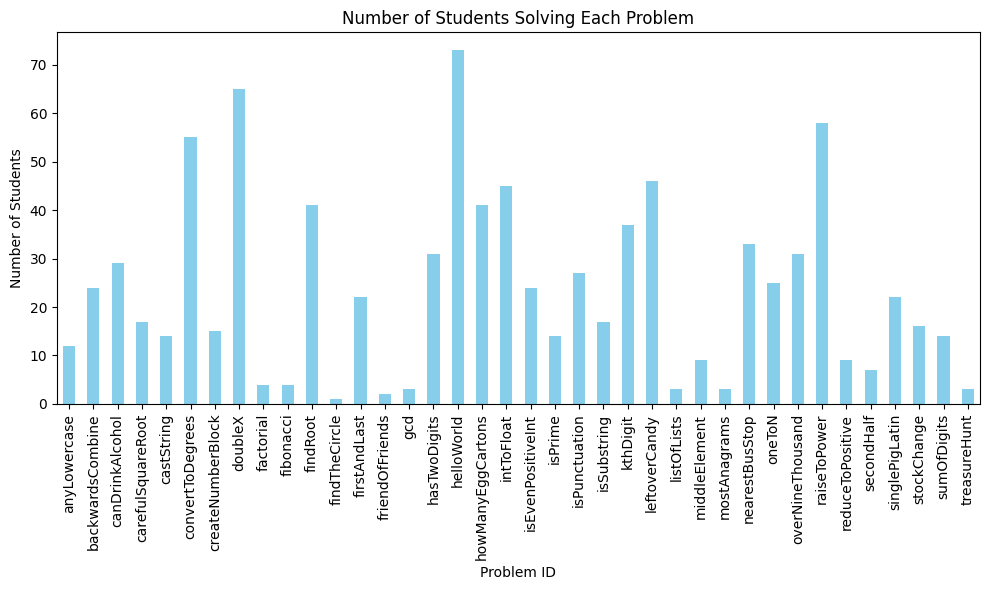

In [22]:
# Filter relevant columns
relevant_columns = ['SubjectID', 'ProblemID', 'EventType']
filtered_data = Data[relevant_columns]

# Count the number of unique students attempting each problem
students_per_problem = filtered_data.groupby('ProblemID')['SubjectID'].nunique()

# Plot the graph
plt.figure(figsize=(10, 6))
students_per_problem.plot(kind='bar', color='skyblue')
plt.title('Number of Students Solving Each Problem')
plt.xlabel('Problem ID')
plt.ylabel('Number of Students')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## **Feature Engineering**

We have added 5 new features which are computed using existing features -

1. **pCorrectForProblem**: This feature represents the average success rate for each problem. It calculates the proportion of correct attempts for each problem. Higher values indicate that the problem is easier or that students have a higher likelihood of solving it correctly.

2. **medAttemptsForProblem**: This feature represents the median number of attempts made by students on a particular problem before solving it correctly. It gives an idea of the difficulty level of the problem. Higher values suggest that the problem is more challenging, requiring more attempts to solve.

3. **priorAttempts**: This feature indicates the number of problems attempted by a student before the current problem. It captures the student's experience level or engagement with the platform. More experienced students might have attempted more problems, potentially indicating higher proficiency.

4. **priorPercentCorrect**: This feature represents the proportion of problems a student has solved correctly before attempting the current problem. It captures the student's past performance and can indicate their overall proficiency or learning trajectory.

5. **priorPercentCompleted**: This feature represents the proportion of problems a student has completed successfully before attempting the current problem. It reflects the student's progress in completing tasks on the platform and may influence their current performance.



In [23]:
def get_problem_stats(data):
    # Calculate the average success rate on each problem and merge it into the data
    problem_stats = data.groupby("ProblemID").agg(pCorrectForProblem=("FirstCorrect", "mean"),
                                                  medAttemptsForProblem=("Attempts", "median")).reset_index()
    return problem_stats

def add_attributes(data, problem_stats):
    data = pd.merge(data, problem_stats, on="ProblemID")

    # Now we want to calculate the prior rate of success/completion for each
    # student before they attempted each problem
    data = data.sort_values(by=["SubjectID", "StartOrder"])

    # Initialize columns
    data["priorPercentCorrect"] = 0.5
    data["priorPercentCompleted"] = 0.5
    data["priorAttempts"] = 0

    last_student = ""
    # Go through each row in the data...
    for i in range(len(data)):
        # If this is a new student, reset our counters
        student = data.loc[i, "SubjectID"]
        if student != last_student:
            attempts = 0
            first_correct_attempts = 0
            completed_attempts = 0
        last_student = student

        data.loc[i, "priorAttempts"] = attempts
        # If this isn't their first attempt, calculate their prior percent correct and completed
        if attempts > 0:
            data.loc[i, "priorPercentCorrect"] = first_correct_attempts / attempts
            data.loc[i, "priorPercentCompleted"] = completed_attempts / attempts

        # Update the number of problems they attempted and got right (on their first try)
        attempts += 1
        if data.loc[i, "FirstCorrect"]:
            first_correct_attempts += 1
        if data.loc[i, "EverCorrect"]:
            completed_attempts += 1

    return data

In [24]:
merged_data = add_attributes(Data, get_problem_stats(Data))
merged_data.head()

,EventType,Order,SubjectID,CodeStateID,ServerTimestamp,ProblemID,Correct,StartOrder,FirstCorrect,EverCorrect,UsedHint,Attempts,pCorrectForProblem,medAttemptsForProblem,priorPercentCorrect,priorPercentCompleted,priorAttempts
0,Submit,1373,S002,1061,2016-02-05T19:46:00,nearestBusStop,1,1373.0,1,1,0,1.0,0.036496,6.0,0.5,0.5,0
137,Submit,1374,S002,1062,2016-02-05T19:48:00,backwardsCombine,1,1374.0,1,1,0,1.0,0.400000,4.0,0.5,0.5,0
182,X-HintRequest,1375,S002,1063,2016-02-05T19:49:00,firstAndLast,0,1375.0,0,1,1,15.0,0.078947,13.0,0.5,0.5,0
183,X-HintRequest,1376,S002,1064,2016-02-05T19:50:00,firstAndLast,0,1375.0,0,1,1,15.0,0.078947,13.0,0.0,1.0,1
184,X-HintRequest,1377,S002,1065,2016-02-05T19:51:00,firstAndLast,0,1375.0,0,1,1,15.0,0.078947,13.0,0.0,1.0,2


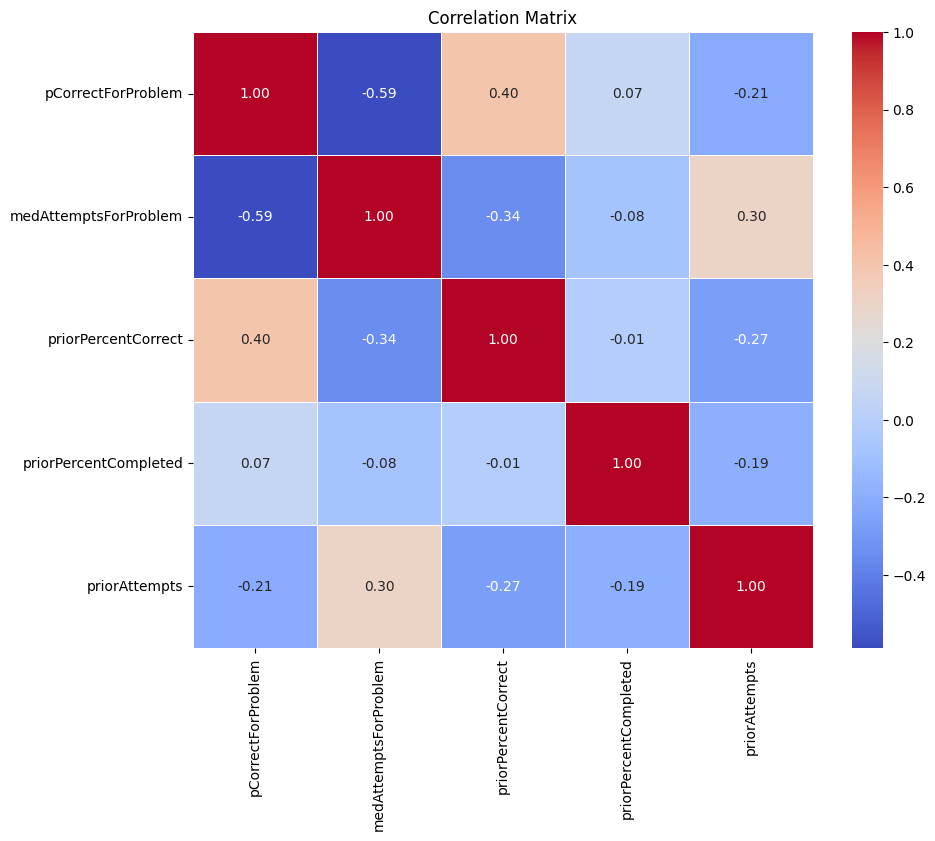

In [25]:
selected_columns = ['pCorrectForProblem', 'medAttemptsForProblem', 'priorPercentCorrect', 'priorPercentCompleted', 'priorAttempts']
selected_df = merged_data[selected_columns]

# Compute the correlation matrix
corr_matrix = selected_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# **Feature Engineering2(Confidence Level)**

In [26]:
def calculate_confidence(row):
    if row['EverCorrect'] == 1:  # If previous attempt was successful
        if row['Attempts'] <= 3:  # If attempts are less than or equal to 3
            return 'High'
        elif row['Attempts'] <= 6:  # If attempts are between 4 and 6
            if row['UsedHint'] == 1:  # If hints were used
                return 'Medium'
            else:
                return 'High'
        else:  # If attempts are more than 6
            return 'Medium' if row['UsedHint'] == 1 else 'Low'
    else:  # If previous attempt was unsuccessful
        return 'Low'

# Apply the function to each row to calculate confidence level
merged_data['Confidence Level'] = merged_data.apply(calculate_confidence, axis=1)

# Display the updated dataset with the new 'Confidence Level' column
print(merged_data)


          EventType  Order SubjectID  CodeStateID      ServerTimestamp  \
0            Submit   1373      S002         1061  2016-02-05T19:46:00   
137          Submit   1374      S002         1062  2016-02-05T19:48:00   
182   X-HintRequest   1375      S002         1063  2016-02-05T19:49:00   
183   X-HintRequest   1376      S002         1064  2016-02-05T19:50:00   
184   X-HintRequest   1377      S002         1065  2016-02-05T19:51:00   
...             ...    ...       ...          ...                  ...   
2849         Submit   2829        SA         2160  2016-02-21T07:16:00   
2900         Submit   2830        SA         2161  2016-02-21T07:18:00   
2901         Submit   2831        SA         2162  2016-02-21T07:19:00   
3095         Submit   2946        SA         2254  2016-02-27T02:28:00   
3096         Submit   2947        SA         2255  2016-02-27T02:34:00   

             ProblemID  Correct  StartOrder  FirstCorrect  EverCorrect  \
0       nearestBusStop        1      

One hot encoding the column

In [27]:
one_hot_encoded = pd.get_dummies(merged_data['Confidence Level'], prefix='Confidence')

merged_data= pd.concat([merged_data, one_hot_encoded], axis=1)

merged_data.drop(columns=['Confidence Level'], inplace=True)

print(merged_data)

          EventType  Order SubjectID  CodeStateID      ServerTimestamp  \
0            Submit   1373      S002         1061  2016-02-05T19:46:00   
137          Submit   1374      S002         1062  2016-02-05T19:48:00   
182   X-HintRequest   1375      S002         1063  2016-02-05T19:49:00   
183   X-HintRequest   1376      S002         1064  2016-02-05T19:50:00   
184   X-HintRequest   1377      S002         1065  2016-02-05T19:51:00   
...             ...    ...       ...          ...                  ...   
2849         Submit   2829        SA         2160  2016-02-21T07:16:00   
2900         Submit   2830        SA         2161  2016-02-21T07:18:00   
2901         Submit   2831        SA         2162  2016-02-21T07:19:00   
3095         Submit   2946        SA         2254  2016-02-27T02:28:00   
3096         Submit   2947        SA         2255  2016-02-27T02:34:00   

             ProblemID  Correct  StartOrder  FirstCorrect  EverCorrect  \
0       nearestBusStop        1      

In [28]:
merged_data.isnull().sum()

EventType                0
Order                    0
SubjectID                0
CodeStateID              0
ServerTimestamp          0
ProblemID                0
Correct                  0
StartOrder               0
FirstCorrect             0
EverCorrect              0
UsedHint                 0
Attempts                 0
pCorrectForProblem       0
medAttemptsForProblem    0
priorPercentCorrect      0
priorPercentCompleted    0
priorAttempts            0
Confidence_High          0
Confidence_Low           0
Confidence_Medium        0
dtype: int64

## **Creating Training and Testing Dataset**

We are forming training and testing dataset by considering derived features with the target as `EverCorrect`.

In [29]:
features = ["pCorrectForProblem", "medAttemptsForProblem", "priorAttempts", "priorPercentCorrect", "priorPercentCompleted","Confidence_High","Confidence_Low","Confidence_Medium"]
target = merged_data["EverCorrect"].astype('int')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(merged_data[features], target, test_size=0.2, random_state=42)
X_train

,pCorrectForProblem,medAttemptsForProblem,priorAttempts,priorPercentCorrect,priorPercentCompleted,Confidence_High,Confidence_Low,Confidence_Medium
1130,0.720000,1.0,0,0.5,0.5,True,False,False
427,0.102564,6.0,2,0.0,0.0,False,True,False
950,0.201835,4.0,0,0.5,0.5,True,False,False
2893,0.070175,4.6,0,0.5,0.5,True,False,False
593,0.031847,13.0,11,0.0,0.0,False,True,False
...,...,...,...,...,...,...,...,...
2838,0.013889,4.6,2,0.0,0.0,False,True,False
1512,0.513514,1.0,0,0.5,0.5,True,False,False
2260,0.017422,16.0,0,0.5,0.5,False,False,True
857,0.201835,4.0,3,0.0,1.0,False,True,False


In [31]:
y_train

1130    1
427     0
950     1
2893    1
593     0
       ..
2838    0
1512    1
2260    1
857     1
329     0
Name: EverCorrect, Length: 2486, dtype: int64

## **Classification and Evaluation**

We selected 3 classifiers - Random Forest, Support Vector Machine, and Logistic Regression. All these models are trained using 10-fold cross validation.

### Random Forest Classifier

In [32]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)

k_folds = 10

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

accuracy_scores = cross_val_score(rf_classifier, X_train, y_train, cv=kf, scoring='accuracy')
precision_scores = cross_val_score(rf_classifier, X_train, y_train, cv=kf, scoring='precision')
recall_scores = cross_val_score(rf_classifier, X_train, y_train, cv=kf, scoring='recall')
f1_scores = cross_val_score(rf_classifier, X_train, y_train, cv=kf, scoring='f1')

mean_accuracy = accuracy_scores.mean()
std_accuracy = accuracy_scores.std()

print("Mean Accuracy:",mean_accuracy)
print("Standard Deviation of Accuracy:",std_accuracy)


mean_precision = precision_scores.mean()

mean_recall = recall_scores.mean()

mean_fscore = f1_scores.mean()

print("Precision:", mean_precision)
print("Recall:", mean_recall)
print("F1-score:", mean_fscore)

Mean Accuracy: 0.982300168415598
Standard Deviation of Accuracy: 0.007019809151357022
Precision: 0.9927269885467229
Recall: 0.9805041654997793
F1-score: 0.9865296839195441


### Support Vector Machine

In [33]:
svc = SVC(random_state=42)

k_folds = 10

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

accuracy_scores2 = cross_val_score(svc, X_train, y_train, cv=kf, scoring='accuracy')
precision_scores2 = cross_val_score(svc, X_train, y_train, cv=kf, scoring='precision')
recall_scores2 = cross_val_score(svc, X_train, y_train, cv=kf, scoring='recall')
f1_scores2 = cross_val_score(svc, X_train, y_train, cv=kf, scoring='f1')

mean_accuracy2 = accuracy_scores2.mean()
std_accuracy2 = accuracy_scores2.std()

print("Mean Accuracy:",mean_accuracy2)
print("Standard Deviation of Accuracy:",std_accuracy2)


mean_precision2 = precision_scores2.mean()

mean_recall2 = recall_scores2.mean()

mean_fscore2 = f1_scores2.mean()

print("Precision:", mean_precision2)
print("Recall:", mean_recall2)
print("F1-score:", mean_fscore2)

Mean Accuracy: 0.9621793626117373
Standard Deviation of Accuracy: 0.012529299132450194
Precision: 0.9974427616274839
Recall: 0.9452136063472014
F1-score: 0.9705148747779043


### Logistic Regression

In [34]:
logistic_reg_model = LogisticRegression(max_iter=130)

k_folds = 10

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

accuracy_scores3 = cross_val_score(logistic_reg_model, X_train, y_train, cv=kf, scoring='accuracy')
precision_scores3 = cross_val_score(logistic_reg_model, X_train, y_train, cv=kf, scoring='precision')
recall_scores3 = cross_val_score(logistic_reg_model, X_train, y_train, cv=kf, scoring='recall')
f1_scores3 = cross_val_score(logistic_reg_model, X_train, y_train, cv=kf, scoring='f1')

mean_accuracy3 = accuracy_scores3.mean()
std_accuracy3 = accuracy_scores3.std()

print("Mean Accuracy:",mean_accuracy3)
print("Standard Deviation of Accuracy:",std_accuracy3)


mean_precision3 = precision_scores3.mean()

mean_recall3 = recall_scores3.mean()

mean_fscore3 = f1_scores3.mean()

print("Precision:", mean_precision3)
print("Recall:", mean_recall3)
print("F1-score:", mean_fscore3)

Mean Accuracy: 0.9818985619898951
Standard Deviation of Accuracy: 0.005170207748233376
Precision: 0.9897081043643856
Recall: 0.9829023588051455
F1-score: 0.9862571395946611


# **Visualising Results**

In [35]:
metrics_df = pd.DataFrame({
    'Models': ['Random Forest Classifier', 'Support Vector Machine', 'Logistic Regression'],
    'Mean Accuracy': [mean_accuracy, mean_accuracy2, mean_accuracy3],
    'Std Accuracy': [std_accuracy, std_accuracy2, std_accuracy3],
    'Mean Precision': [mean_precision, mean_precision2, mean_precision3],
    'Mean Recall': [mean_recall, mean_recall2, mean_recall3],
    'Mean F1-score': [mean_fscore, mean_fscore2, mean_fscore3]
})

# Set the Experiment column as the index
metrics_df.set_index('Models', inplace=True)

pd.set_option('display.max_columns', None)
# Display the DataFrame
print(metrics_df)

                          Mean Accuracy  Std Accuracy  Mean Precision  \
Models                                                                  
Random Forest Classifier       0.982300      0.007020        0.992727   
Support Vector Machine         0.962179      0.012529        0.997443   
Logistic Regression            0.981899      0.005170        0.989708   

                          Mean Recall  Mean F1-score  
Models                                                
Random Forest Classifier     0.980504       0.986530  
Support Vector Machine       0.945214       0.970515  
Logistic Regression          0.982902       0.986257  


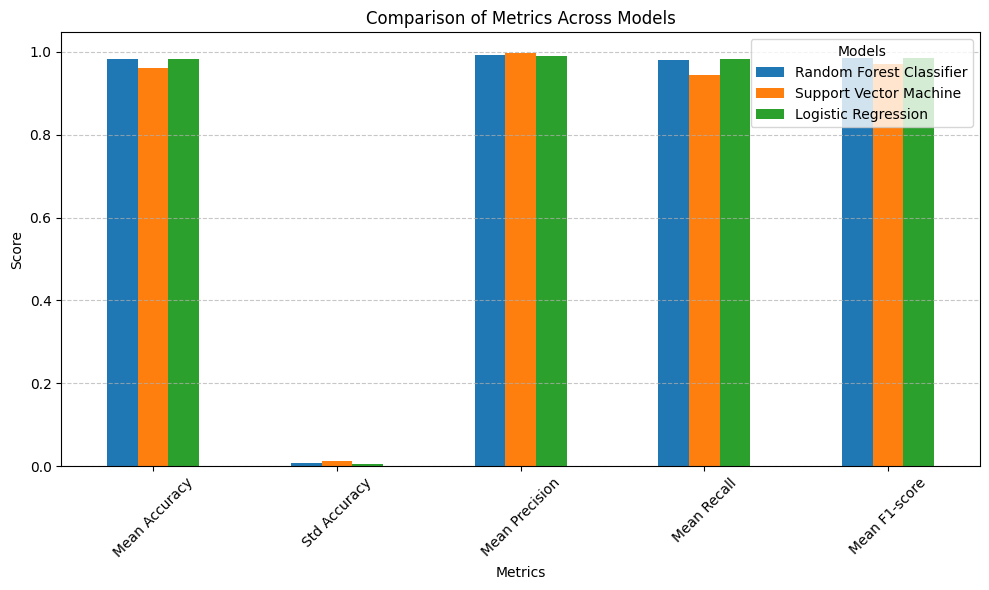

In [36]:
metrics_df = metrics_df.T

# Plotting
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Metrics Across Models')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.xticks(rotation=45)
plt.legend(title='Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **Conclusion**

Based on the evaluation metrics and considering the trade-offs between precision, recall, and overall accuracy, we selected Random Forest Classifier as our clasification model.

The Random Forest Classifier achieved the highest accuracy among the three classifiers (98%), indicating its overall effectiveness in predicting student success in solving programming tasks.
The precision, recall, and F1-score are also relatively high, indicating a good balance between identifying positive instances correctly (precision) and capturing all positive instances (recall).
With a high recall of 98%, the Random Forest Classifier effectively identifies the majority of positive instances.


In [37]:
rf_classifier.fit(X_train,y_train)
predicted= pd.DataFrame(rf_classifier.predict(X_test), columns=['Predicted_EverCorrect'])
print(pd.DataFrame(predicted,y_test).head())

             Predicted_EverCorrect
EverCorrect                       
1                                1
1                                1
1                                1
1                                1
1                                1
